# Estimating heart rate using PPG signals from Phone Camera video of Finger tip.

In [67]:
Link to Video demonstration: #Importing required libraries 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, convolve, find_peaks,filtfilt

In [68]:
# Create a VideoCapture object and read from input file
video_data = cv2.VideoCapture('cam.mp4')

#Information about the video
fps = video_data.get(cv2.CAP_PROP_FPS)
frame_count = int(video_data.get(cv2.CAP_PROP_FRAME_COUNT))
vid_length = frame_count/fps
time_bw_frame=1/fps

In [69]:
#declaring array for storing R,G,B from different frames
R=[]
G=[]
B=[]

In [70]:
#the loop will iterate over each image and take average of R, G and B values of the image and then store in an array
while True:
    ret,frame=video_data.read()
    
    #loop breaking when end of video reached, the ret is the value returned from frame reading and at end its false
    if ret==False:
        break
    
    #counting total no of pixels, sum of each value to take average later
    no_of_pixels=0
    sumr=0
    sumg=0
    sumb=0
    
    #loop for pixel row (height), only pixels in mid are selected for best results
    for i in frame[int((len(frame)-100)/2):int((len(frame)+100)/2)]:
        #loop for pixel column (width), only pixels in mid are selected for best results
        for j in i[int((len(frame[0])-100)/2):int((len(frame[0])+100)/2)]:
            sumr=sumr+j[2];
            sumg=sumg+j[1];
            sumb=sumb+j[0];
            no_of_pixels=no_of_pixels+1
    R.append(sumr/no_of_pixels)
    G.append(sumg/no_of_pixels)
    B.append(sumb/no_of_pixels)

In [71]:
#discarding first few frames and last few corresponding to first few seconds and last few seconds respectively as these times in video contains errors as user will be adjusting and removing finger
R=R[100:-100]
G=G[100:-100]
B=B[100:-100]

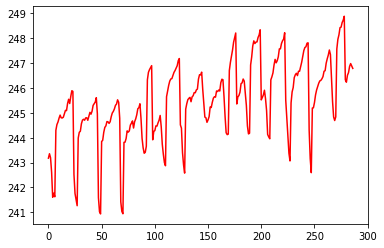

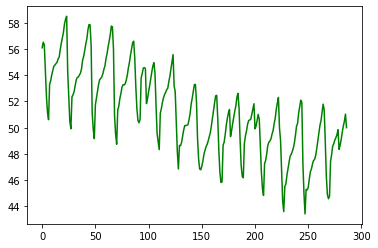

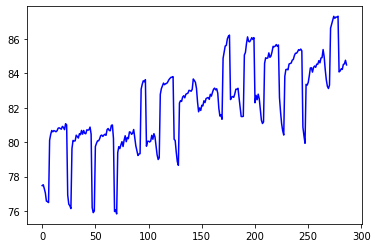

In [72]:
#plotting R,G,B values for reference
plt.figure()
plt.plot(R ,'r')
plt.show()

plt.figure()
plt.plot(G ,'g')
plt.show()

plt.figure()
plt.plot(B ,'b')
plt.show()

# Red value is choosen for further filtering. The signal is bandpassed, squared and moving averaged

In [73]:
#declaring variables for filters
r_cutoff_high=8
r_cutoff_low=25
r_order_of_bandpass=5
r_sampling_rate=2*int(fps+1)
r_average_filter_sample_length=7

#calculating high pass filter co-efficient
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs   #Nyquist
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a  #returns co-efficients for filter


#calculating low pass filter co-efficient
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a   #returns co-efficients for filter


#Bandpass filter - obtain co-efficient from above function and applies left and right filters
def filter_all(data, fs, order=5,cutoff_high=8,cutoff_low=25):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    highpassed_signal = filtfilt(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    bandpassed_signal = filtfilt(d, c, highpassed_signal)
    #returns bandpassed signal
    return bandpassed_signal

#Bandpass+square+average
def process_signal(y,order_of_bandpass,high,low,sampling_rate,average_filter_sample_length):
   
    #filtered singla is the bandpassed signal obtained from above functions, it is obtained below by function call
    filtered_signal=filter_all(y,sampling_rate,order_of_bandpass,high,low)
    
    #squaring to de-congest signals
    squared_signal=filtered_signal**2
    
    
    #taking moving average
    b = (np.ones(average_filter_sample_length))/average_filter_sample_length #numerator co-effs of filter transfer function
    a = np.ones(1)  #denominator co-effs of filter transfer function
    averaged_signal = convolve(squared_signal,b) 
    averaged_signal = filtfilt(b,a,squared_signal)
    #returning each stage of signal, most of these will be used for plotting. 
    return averaged_signal


#calling function to get processed signal
r_averaged=process_signal(R,r_order_of_bandpass,r_cutoff_high,r_cutoff_low,r_sampling_rate,r_average_filter_sample_length);

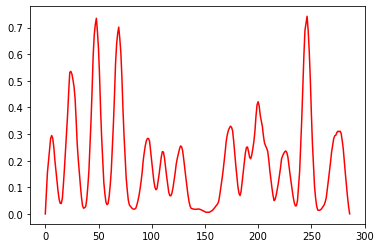

In [74]:
#plotting the averaged signal
plt.figure()
plt.plot(r_averaged ,'r')
plt.show()

In [75]:
#peak detection from averaged signal and storage of peak time in array
r_min_peak=min(r_averaged)+(max(r_averaged)-min(r_averaged))/8
r_peaks=find_peaks(r_averaged,height=r_min_peak) #returns peak height and index at which peak occured

In [76]:
#calculating average frames between peaks
diff_sum=0
total_peaks=len(r_peaks[0])
i=0
while i<total_peaks-1:
    diff_sum=diff_sum+r_peaks[0][i+1]-r_peaks[0][i]
    i=i+1

avg_diff=diff_sum/(total_peaks-1)

In [77]:
#final calculation of Heart rate and error percentage
avg_time_bw_peaks=avg_diff*time_bw_frame

bpm=60/avg_time_bw_peaks
    

print("Calculated Heart rate = ",bpm)

#input the real heart rate
real_hr=int(input("Enter real heart rate for error calculations: "))
print((abs(real_hr-bpm)/real_hr)*100," %")

Calculated Heart rate =  86.34402670389697
Enter real heart rate for error calculations: 84
2.790507980829729  %
